In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import seaborn as sns

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"

# Output path info
OUTDIR = "pdfs/"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

In [7]:
# Load expression data
coldata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/columns_metadata.csv")
rowdata = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/rows_metadata.csv")
brainspan = pd.read_csv("/storage/resources/datasets/brainspan/RNA-Seq_Gencode_genes_matrix_csv/expression_matrix.csv",
                  names=coldata["column_num"])
brainspan.index = list(rowdata["gene_symbol"])

# Load per-locus mutation info
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Aug20.locus_stats_rmoutlierfams.tab"
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Convert locus file to hg19
coords = pd.read_csv("/storage/mgymrek/ssc-denovos/for-gtex/ssc_hg19_coords.bed", sep="\t",
                     names=["chrom1","pos_hg19","end_hg19","coords_hg38"])
coords = coords[coords["chrom1"].apply(lambda x: "X" not in x and "Y" not in x and "_" not in x)]
coords["chrom"] = coords["chrom1"].apply(lambda x: GetChrom(x))
coords["pos"] = coords["coords_hg38"].apply(lambda x: int(x.split(":")[1]))
data = pd.merge(data, coords[["chrom","pos","pos_hg19"]], on=["chrom","pos"])

In [8]:
# Get case-only and ctrl-only genes
def GetGene(x):
    if x["FEATURE-CODING"]>0: return x["gene-coding"]
    if x["FEATURE-UTR5"]>0: return x["gene-utr5"]
    if x["FEATURE-UTR3"]>0: return x["gene-utr3"]
    else: return x["TSS_GENE"]

usecols = (adata["FEATURE-PROMOTER5kb"]>0) | (adata["FEATURE-CODING"]>0) | (adata["FEATURE-UTR5"]>0) #| (adata["FEATURE-FETALBRAINTSS"]>0)
adata["gene"] = adata.apply(GetGene, 1)
genes_cases = set(adata[(adata["phenotype"]==2) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
genes_ctrls = set(adata[(adata["phenotype"]==1) & usecols]["gene"]).intersection(set(rowdata["gene_symbol"]))
both = genes_cases.intersection(genes_ctrls)
genes_cases = genes_cases.difference(both)
genes_ctrls = genes_ctrls.difference(both)

# Get expression for each
means_cases = []
means_ctrls = []
medians_cases = []
medians_ctrls = []
pvals = []

for i in range(1, (brainspan.shape[1])+1):
    cols = i
    mean_ctrl = np.mean(brainspan.loc[genes_ctrls,cols])
    mean_case = np.mean(brainspan.loc[genes_cases,cols])
    means_cases.append(mean_case)
    means_ctrls.append(mean_ctrl)
    median_ctrl = np.median(brainspan.loc[genes_ctrls,cols])
    median_case = np.median(brainspan.loc[genes_cases,cols])
    medians_cases.append(median_case)
    medians_ctrls.append(median_ctrl)
    expr_ctrl = np.log(brainspan.loc[genes_ctrls,cols]+0.01)
    expr_case = np.log(brainspan.loc[genes_cases,cols]+0.01)
    pvals.append(scipy.stats.ks_2samp(expr_ctrl, expr_case, alternative="greater")[1])
    
coldata["mean_case"] = means_cases
coldata["mean_ctrl"] = means_ctrls
coldata["median_case"] = medians_cases
coldata["median_ctrl"] = medians_ctrls
coldata["pval"] = pvals

In [9]:
timepoints = ["8 pcw", "9 pcw", "13 pcw", "16 pcw", "21 pcw", "24 pcw", "37 pcw",
             "4 mos", "10 mos", "3 yrs", "8 yrs","18 yrs", "36 yrs", "37 yrs"]
structures = sorted(set(coldata["structure_acronym"]))
structures = [item for item in structures if item not in ["CB","LGE","CGE","URL","DTH","M1C-S1C","Ocx",
                                                         "MGE","PCx","TCx"]]

fcdata = np.zeros((len(structures), len(timepoints)))
pvaldata = np.zeros((len(structures), len(timepoints)))

coldata["FC"] = coldata.apply(lambda x: x["median_case"]/x["median_ctrl"], 1)

for i in range(len(structures)):
    for j in range(len(timepoints)):
        plotdata = coldata[(coldata["structure_acronym"]==structures[i]) & 
                           (coldata["gender"]=="M") &
                           (coldata["age"] == timepoints[j])]
        if plotdata.shape[0] == 0:
            fcdata[i,j] = np.nan
            pvaldata[i,j] = np.nan
            continue
        pval = np.min(plotdata["pval"])
        print(pval)
        pvaldata[i,j] = -1*np.log10(pval)
        fcdata[i,j] = np.max(plotdata["FC"])
    

0.008245933068729786
0.018422522923422075
0.039040226333495104
0.09453446217985337
0.017845525959747664
0.022810389121792358
0.03835438521289117
0.03774392998026488
0.022810389121792358
0.02298676781840411
0.018899828739808024
0.015395226462763792
0.0016410268045965607
0.012348304005783196
0.019422912252226074
0.04065874627216735
0.02043384725847855
0.007312701483082113
0.026451438526678667
0.0029720758976261303
0.029095643747288742
0.013994094784443432
0.03024759707327949
0.018934023140615933
0.056822615088924486
0.024156798196534206
0.0055389857109951
0.010035813318824015
0.013159810716085756
0.01635201673097456
0.02429723738381592
0.014632869268184034
0.013627618479568523
0.04947597335335572
0.000807218313790257
0.012920018860297902
0.0032601370642538602
0.052414701836994246
0.020755706735481154
0.06516725991661217
0.042937390575001545
0.10765276995953248
0.01863646178175699
0.016782037443288766
0.0320202281559036
0.07341231104292578
0.02079343742703261
0.03249096970839639
0.0044135

8 pcw
(59.68682861372412, 5.909273570778429e-07)
9 pcw
(50.2580234309247, 2.392714827216367e-07)
13 pcw
(129.0912199377901, 6.278198857545824e-15)
16 pcw
(110.63040567253762, 1.3699636951922735e-10)
21 pcw
(108.20572612312728, 2.27624539842126e-11)
24 pcw
(105.62319217966686, 8.502030392374363e-10)
37 pcw
(95.78348699107833, 2.7921625116998487e-08)
4 mos
(101.93458055028877, 3.1973020445830563e-09)
10 mos
(65.61506634656945, 9.309916603609527e-07)
3 yrs
(108.17402711395131, 2.304019560160198e-11)
8 yrs
(100.04901853552603, 6.248602524327828e-09)
18 yrs
(98.06131339021726, 2.690884136800547e-10)
36 yrs
(90.69066859276319, 1.6079445335151976e-07)
37 yrs
(98.095547701582, 1.2444281097788667e-08)


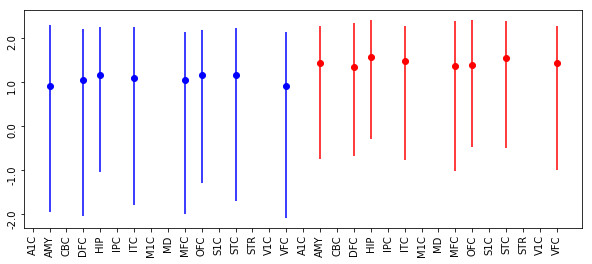

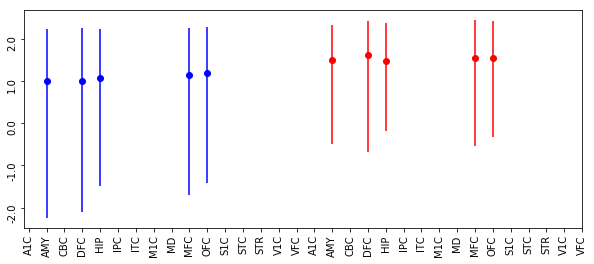

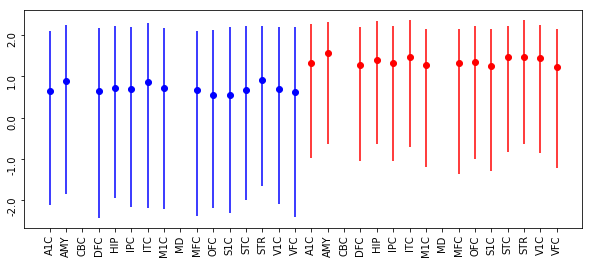

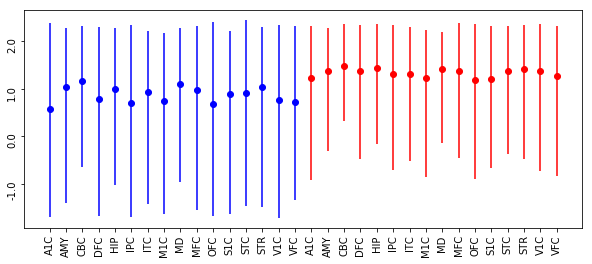

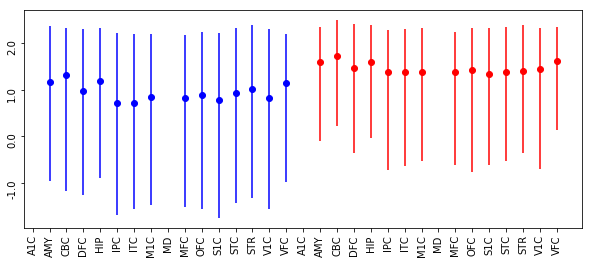

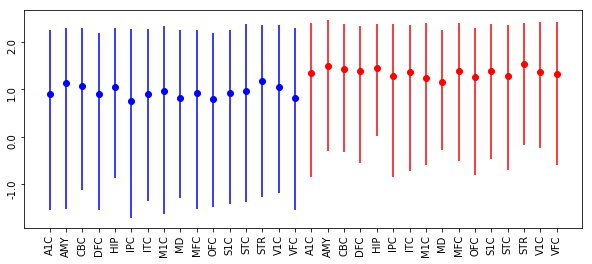

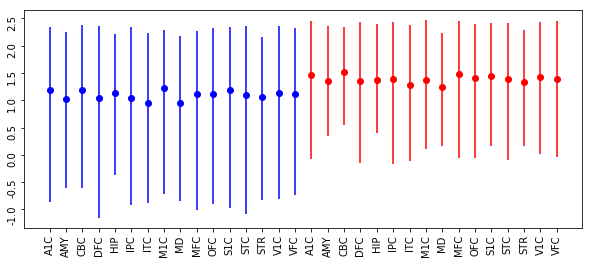

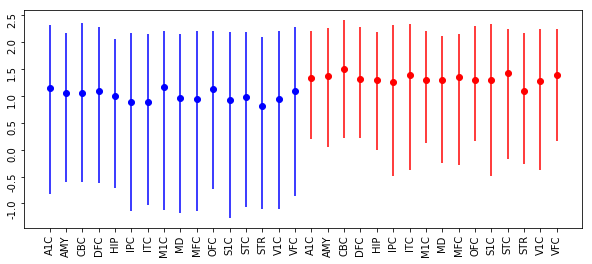

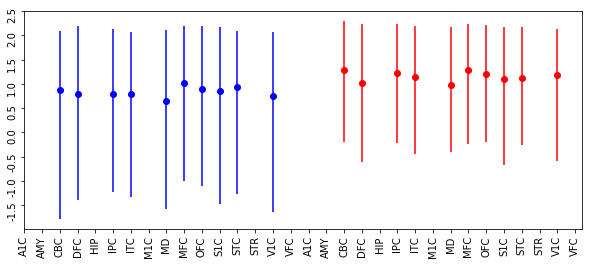

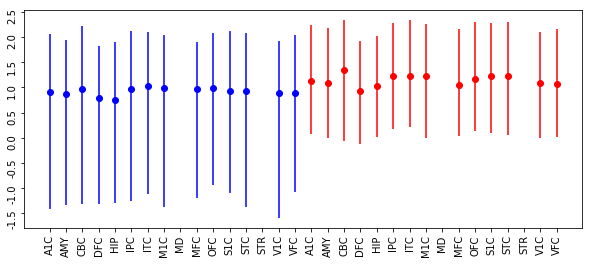

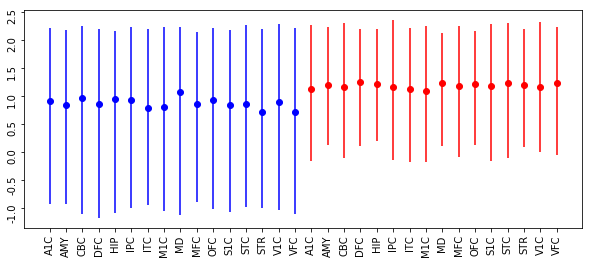

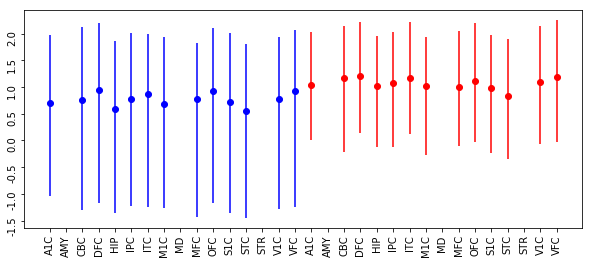

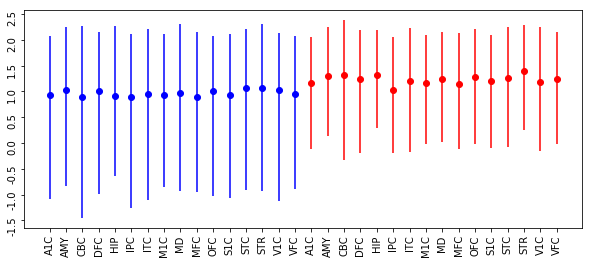

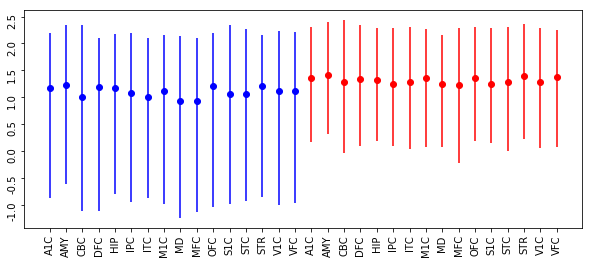

In [13]:
tpvals = []

for timepoint in timepoints:
    meds_case = []
    lows_case = []
    highs_case = []
    meds_ctrls = []
    lows_ctrls = []
    highs_ctrls = []

    positions_case=[]
    positions_ctrls=[]

    colors = []
    pos = 0
    
    pvals = []
    
    # Then controls
    for structure in structures:
        positions_ctrls.append(pos)
        colors.append("blue")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_ctrls.append(np.nan)
            lows_ctrls.append(np.nan)
            highs_ctrls.append(np.nan)
            continue
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)
        meds_ctrls.append(np.median(expr_ctrls))
        lows_ctrls.append(np.median(expr_ctrls)-np.percentile(expr_ctrls, q=25))
        highs_ctrls.append(np.percentile(expr_ctrls, q=75)-np.median(expr_ctrls))

    # First cases
    for structure in structures:
        positions_case.append(pos)
        colors.append("red")
        pos += 1
        try:
            col = plotdata = coldata[(coldata["structure_acronym"]==structure) & (coldata["gender"]=="M") &
                           (coldata["age"]==timepoint)]["column_num"].values[0]
        except:
            meds_case.append(np.nan)
            lows_case.append(np.nan)
            highs_case.append(np.nan)
            continue
        expr_cases = np.log(brainspan.loc[genes_cases, col]+0.01)
        expr_ctrls = np.log(brainspan.loc[genes_ctrls, col]+0.01)

        meds_case.append(np.median(expr_cases))
        lows_case.append(np.median(expr_cases)-np.percentile(expr_cases, q=25))
        highs_case.append(np.percentile(expr_cases, q=75)-np.median(expr_cases))

        pvals.append(scipy.stats.mannwhitneyu(expr_cases, expr_ctrls, alternative="greater")[1])
        
    # Now plot
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(111)
    ax.errorbar(positions_case, meds_case, fmt="o", color="red", yerr=[lows_case, highs_case])
    ax.errorbar(positions_ctrls, meds_ctrls, fmt="o", color="blue", yerr=[lows_ctrls, highs_ctrls])
    ax.set_xticks(positions_case+positions_ctrls)
    ax.set_xticklabels(structures*2, rotation=90)
    ax.set_yticklabels(ax.get_yticks(), rotation=90)
    fig.savefig("pdfs/Figure4_lineplot_%s.pdf"%timepoint)

    # Get fisher p-value
    print(timepoint)
    print(scipy.stats.combine_pvalues(pvals))
    tpvals.append(scipy.stats.combine_pvalues(pvals)[1])


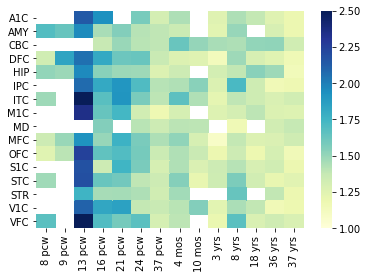

In [14]:
# Plot heatmap of fold change
fig = plt.figure()
ax = fig.add_subplot(111)
hm = sns.heatmap(fcdata,  xticklabels=timepoints, yticklabels=structures, ax=ax,  cmap="YlGnBu",
                vmin=1.0, vmax=2.5)
fig.savefig("pdfs/Figure4_FC_heatmap.pdf")

Adipose-Subcutaneous
MannwhitneyuResult(statistic=5752844.0, pvalue=0.5442147402069603)
0.27923124804764343
3444
3346
Adipose-Visceral
MannwhitneyuResult(statistic=5663156.0, pvalue=0.6495879772549781)
0.40863287574433793
3428
3322
Artery-Aorta
MannwhitneyuResult(statistic=5764604.0, pvalue=0.05413761963843985)
0.4945513874062911
3404
3312
Artery-Tibial
MannwhitneyuResult(statistic=5756577.0, pvalue=0.14526848235679002)
0.4132875408805291
3417
3320
Brain-Caudate
MannwhitneyuResult(statistic=5625602.0, pvalue=0.03525661252016193)
0.0370807677916905
3367
3258
Brain-Cerebellum
MannwhitneyuResult(statistic=5421640.0, pvalue=0.5005248140209398)
0.4090826182442524
3354
3233
Cells-Transformedfibroblasts
MannwhitneyuResult(statistic=5322834.0, pvalue=0.48546809275742087)
0.38253796774843934
3324
3201
Esophagus-Mucosa
MannwhitneyuResult(statistic=5735753.0, pvalue=0.35528494614918305)
0.3002003768205024
3426
3331
Esophagus-Muscularis
MannwhitneyuResult(statistic=5738606.0, pvalue=0.620730589167

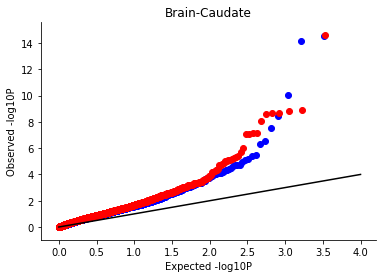

In [16]:
# Load gtex data
# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
def concat(x):
    return ",".join(x)

TISSUES=["Adipose-Subcutaneous",
         "Adipose-Visceral",
         "Artery-Aorta",
         "Artery-Tibial",
         "Brain-Caudate",
         "Brain-Cerebellum",
         "Cells-Transformedfibroblasts",
         "Esophagus-Mucosa",
         "Esophagus-Muscularis",
         "Heart-LeftVentricle",
         "Lung", 
         "Muscle-Skeletal", 
         "Nerve-Tibial",
         "Skin-NotSunExposed",
         "Skin-SunExposed", 
         "Thyroid",
         "WholeBlood"]

pvals = []

def GetXvals(size):
    # Get quantiles of uniform 0,1
    # return sorted -1*log10
    step = 1.0/size
    vals = np.array([step*(i+1) for i in range(size)])
    return -1*np.log10(vals)
    
for tissue in TISSUES:
    print(tissue)
    GTEXFILE = "/storage/mgymrek/gtex-estrs/revision/mastertables/%s_master.tab"%tissue
    gtex = pd.read_csv(GTEXFILE, sep="\t")
    gtex["chrom"] = gtex["chrom"].apply(lambda x: GetChrom(x))
    gtex["pos_hg19"] = gtex["str.start"].apply(int)
    gtex = gtex[~np.isnan(gtex["linreg.pval"])]
    gtex["linreg.beta"] = gtex["linreg.beta"].apply(abs)
    gtex = gtex.groupby(["chrom","pos_hg19","str.motif.forward"], as_index=False).agg({"linreg.pval": np.min, "linreg.beta": np.max, "gene.name": concat})

    merged = pd.merge(gtex, data, on=["chrom","pos_hg19"])
    #merged = merged[merged["str.motif.forward"].apply(len)>1]

    aff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_aff"]>0) & (merged["mut_unaff"]==0)].sort_values("linreg.pval")["linreg.pval"])))
    unaff_pvals = -1*np.log10(sorted(list(merged[(merged["mut_unaff"]>0)& (merged["mut_aff"]==0)].sort_values("linreg.pval")["linreg.pval"])))

    print(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater"))
    print(scipy.stats.ttest_ind(aff_pvals, unaff_pvals)[1]/2)
          
    print(len(aff_pvals))
    print(len(unaff_pvals))
    pvals.append(scipy.stats.mannwhitneyu(aff_pvals, unaff_pvals, alternative="greater")[1])
    if tissue == "Brain-Caudate":
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(GetXvals(len(unaff_pvals)), unaff_pvals, color="blue")
        ax.scatter(GetXvals(len(aff_pvals)), aff_pvals, color="red")
        ax.plot([0,4],[0,4], color="black")
        ax.set_title(tissue)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
        ax.set_xlabel("Expected -log10P")
        ax.set_ylabel("Observed -log10P")
        fig.savefig(os.path.join(OUTDIR, "Figure4_eSTR_QQ_%s.pdf"%tissue))

{0, 3, -3}
(-0.29682541524019174, 0.002003471880950706)
   str  expr
0   -3   3.0
1    0  88.0
2    3  15.0


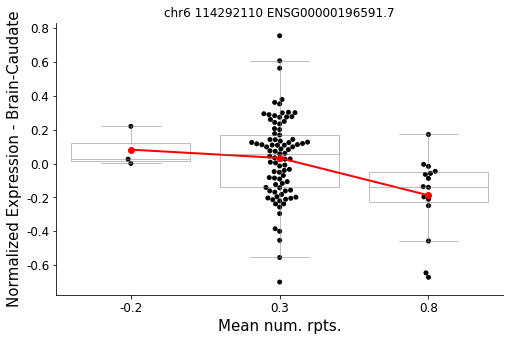

{0, 3, -3, 6}
(-0.1816972859268684, 0.000805024237004622)
   str   expr
0   -3   16.0
1    0  262.0
2    3   56.0
3    6    3.0


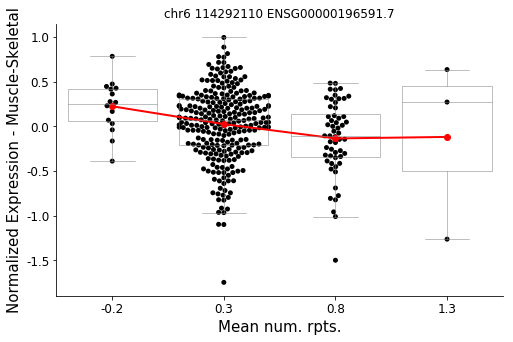

In [24]:
SAVEPLOT = True
# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "strreg", "%s_strreg.tab"%t), sep="\t", usecols=["gene","str.start","p.wald"])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)
    
def ExtractData(gene, chrom, start, tissue, newdata=True):
    if "(" in tissue: tissue = tissue.split("(")[0]
    #vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    vcf = "/storage/mgymrek/ssc-denovos/for-gtex/Merged_STRs_all_samples.vcf.gz" 
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    if newdata:
        expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Review_Rerun/%s/Corr_Expr.csv"%tissue
    else: expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    #expr = "/storage/mgymrek/ssc-denovos/for-gtex/Brain-Corr-Expr.csv" 
    allgenes = open(expr,"r").readline().split(",")
    colnum = allgenes.index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, newdata=True, period=None):
    ExtractData(gene, chrom, start, tissue, newdata=newdata)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    fig = plt.figure()
    fig.set_size_inches((8,5))
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]
    print(set(data["str"]))
    boxcol = "gray"
    print(scipy.stats.pearsonr(data["str"], data["expr"]))

    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="black", zorder=0)
    sns.boxplot(x="str", y="expr", ax=ax, data=data, color="white", linewidth=0.5, 
                boxprops={'facecolor':'None', 'edgecolor': boxcol}, showfliers=False)
    # Set box properties
    for i,artist in enumerate(ax.artists):
        artist.set_edgecolor(boxcol)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        x = 5
        for j in range(i*x,i*x+x):
            line = ax.lines[j]
            line.set_color(boxcol)
            line.set_mfc(boxcol)
            line.set_mec(boxcol)
    totals = data.groupby("str", as_index = False).agg({"expr": len})
    print(totals.sort_values("str"))
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="red", marker="o", linewidth=2)
    ax.set_xlabel("Mean num. rpts.", size=15)
    ax.set_ylabel("Normalized Expression - %s"%tissue, size=15)
    ax.set_xticklabels(["%.1f"%((item*0.5+reflen)/period) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.1f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("%s %s %s"%(chrom, start,gene))
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)
    
# HDAC2
chrom = "chr6"
start = 114292110
end = 114292110
gene = "ENSG00000196591.7"
tissue = "Brain-Caudate"
period = 3
offset = 0
reflen = (end+1+offset-start)
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, period=period)

chrom = "chr6"
start = 114292110
end = 114292110
gene = "ENSG00000196591.7"
tissue = "Muscle-Skeletal"
period = 3
offset = 0
reflen = (end+1+offset-start)
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, period=period)